**Homework 3:** *Data-Driven Modeling for Engineers* (ME 2063) - Instructor: H. Babaee,  **Due: 4:00 pm, February 2, 2023.**

Consider a heat conduction in a rod where the heat transfer in the rod can be accurately modeled via the one-dimensional heat conduction model given below: 
\begin{equation}
k\frac{d^2T(x)}{dx^2} + q(x) = 0 \quad \quad (1),
\end{equation}
where $0 \leq x \leq 1$, $T(x)$ is the temperature and $k=1$ is the conductivity coefficient.   The rod is subject to a distributed heat source according to $q(x)= 10\exp(\sin(30 x))$.   Imagine there are only 8 noisy measurement of temperature and none of these measurements are at the boundaries at $x=0$ or 1. The objective of this assignment is to infer the temperature profile using physics-informed regression, i.e., by by using the measurements as well as enforcing the physics.


You can  download `Data_HW3.mat` from Canvas that contains the 8 noisy measurements as well as the truth.  You can use the following lines of code to import x\_truth, y\_truth and  x\_train, y\_train, where y\_truth is the true temperature at location x\_truth and y\_train is the noisy temperature measurements at location x_\train. 

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
# load the data set
data = scipy.io.loadmat('Data_HW3.mat')

x_truth = data["x_truth"]
y_truth = data["y_truth"]

x_train = data["x_train"]
y_train = data["y_train"]

x_truth.shape, y_truth.shape, x_train.shape, y_train.shape

((200, 1), (200, 1), (8, 1), (8, 1))

Consider the *Gaussian radial basis (GRB) functions* as the basis function, where $T(x) = \sum_{i=0}^{K-1} \theta_i \phi_i(x)$ where
$\Phi(x)=[\phi_0(x), \phi_1(x), \dots, \phi_{K-1}(x)]$, where:
\begin{align*}
    \phi_0(x) &= 1\\
    \phi_i(x) &= \exp\big(-\frac{(x-\mu_i)^2}{s^2}\big), \quad, i=1,2, \dots, K-1, 
\end{align*}
 $s=0.1$ and $\mu$=`np.linspace(0,1,K-1)`.


1.   Write down the physics-informed loss function ($E(\boldsymbol{\theta})$) and set $\partial E/\partial \boldsymbol{\theta}= \mathbf{0}$ and find an expression for the optimal $\boldsymbol{\theta}$.

2.   Write a Python program to compute the optimal regression weights.
3. Consider $K=60$ and enforce the residual of Equation (1) at N\_Model=200 equidistant points: `x_Model = np.linspace(0,1,N_Model)`.  Solve the physics-informed regression and plot the truth, the measurements and the regressed temperature in one figure. Legend accordingly. 
4. Build another regression model by using the 8 measurement *only*. Plot the truth, the measurements and the regressed temperature in one figure. Legend accordingly. 
5. Build another regression model by only enforcing the model at 200 equidistant points. Do not use the noisy measurements in this regression model.     Plot the truth, the measurements and the regressed temperature in one figure. Legend accordingly. 
6. Out of the three models that were built in Parts 3-5, which one is more accurate?  


Part 1.

We will use the notation $\hat{T}(x;\theta)$ to refer to the temperature regression model and $T \in \mathbb{R}^{N_{data}}$ to refer to the data set of measured temperature values. The physics-informed loss function can be stated as:

\begin{align*}
    E(\theta) &= \frac{1}{2 N_{data}} \|\hat{T}(x;\theta) - T\|^2 + \frac{1}{2 N_{model}} \|k \frac{d^2}{dx^2} \hat{T}(x;\theta) + q(x)\|^2
\end{align*}

Noting that $\hat{T}(x;\theta) = \Phi(x) \theta$ and letting $\Psi(x) = k \frac{d^2}{dx^2} \Phi(x)$, we can derive a closed form solution for the optimal value of $\theta$:

\begin{align*}
    0 &= \frac{\partial}{\partial \theta} E(\theta) \\
    0 &= \frac{\partial}{\partial \theta} \left( \frac{1}{2 N_{data}} \|\hat{T}(x;\theta) - T\|^2 + \frac{1}{2 N_{model}} \|k \frac{d^2}{dx^2} \hat{T}(x;\theta) + q(x)\|^2 \right) \\
    0 &= \frac{\partial}{\partial \theta} \left( \frac{1}{2 N_{data}} \|\Phi(x) \theta - T\|^2 + \frac{1}{2 N_{model}} \|  \Psi(x) \theta + q(x)\|^2 \right) \\
    0 &= \frac{1}{2 N_{data}} \frac{\partial}{\partial \theta} \|\Phi(x) \theta - T\|^2 + \frac{1}{2 N_{model}} \frac{\partial}{\partial \theta} \|\Psi(x) \theta + q(x)\|^2 \\
    0 &= \frac{1}{N_{data}} \Phi(x)^\top (\Phi(x) \theta - T ) + \frac{1}{N_{model}} \Psi(x)^\top (\Psi(x) \theta + q(x))
\end{align*}

We can rearrange this into a system of linear equations:

\begin{align*}
    \left( \frac{1}{N_{data}} \Phi(x)^\top \Phi(x) + \frac{1}{N_{model}} \Psi(x)^\top \Psi(x) \right) \theta &= \left( \frac{1}{N_{data}} \Phi(x)^\top T - \frac{1}{N_{model}} \Psi(x)^\top q(x) \right) \\
\end{align*}

Which we can solve to attain the optimal value of the parameter vector $\theta$:

\begin{align*}
    \theta &= \left( \frac{1}{N_{data}} \Phi(x)^\top \Phi(x) + \frac{1}{N_{model}} \Psi(x)^\top \Psi(x) \right)^{-1} \left( \frac{1}{N_{data}} \Phi(x)^\top T - \frac{1}{N_{model}} \Psi(x)^\top q(x) \right) \\
\end{align*}

In [3]:
# Part 2.

def gauss_basis(K, s):
    def phi(x, deriv=0):
        phi_x = np.zeros((len(x), K))
        mu = np.linspace(0, 1, K - 1)
        if deriv == 0:
            phi_x[:,0] = 1
            phi_x[:,1:] = np.exp(-(x - mu)**2 / s**2)
        elif deriv == 1:
            phi_x[:,1:] = np.exp(-(x - mu)**2 / s**2) * 2 * (x - mu) / s**2
        elif deriv == 2:
            phi_x[:,1:] = np.exp(-(x - mu)**2 / s**2) * (4 * (x - mu)**2 - 2 * s**2) / s**4
        return phi_x
    return phi

def heat_pde(k, basis):
    def psi(x):
        return k * basis(x, deriv=2)
    return psi

def expon_f(x):
    return 10 * np.exp(np.sin(30 * x))

N_data = len(x_train)
phi = gauss_basis(K=60, s=0.1)
phi_x = phi(x_train)

N_pde = 200
x_pde = np.linspace(0, 1, N_pde)[:,np.newaxis]
psi = heat_pde(k=1, basis=phi)
psi_x = psi(x_pde)
f_x = -expon_f(x_pde)

A_data = phi_x.T @ phi_x
b_data = phi_x.T @ y_train

A_pde = psi_x.T @ psi_x
b_pde = psi_x.T @ f_x

A_both = A_data / N_data + A_pde / N_pde
b_both = b_data / N_data + b_pde / N_pde

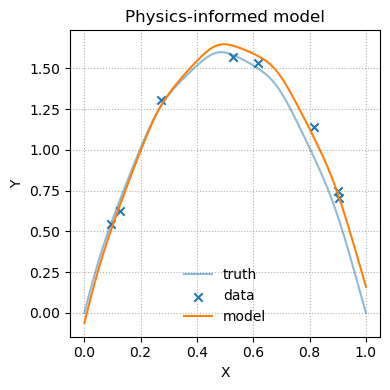

In [4]:
# Part 3.
theta0 = np.linalg.solve(A_both, b_both)
y_pred = phi(x_truth) @ theta0

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Physics-informed model')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(linestyle=':')
ax.plot(x_truth, y_truth, alpha=0.5, label='truth')
ax.scatter(x_train, y_train, marker='x', label='data')
ax.plot(x_truth, y_pred, label='model')
#ax.plot(x_plot, yp_poly, label='poly (K=4)', color='C1')
#ax.plot(x_plot, yp_gauss, label='gauss (K=10)', color='C2')
ax.legend(frameon=False)
fig.tight_layout()

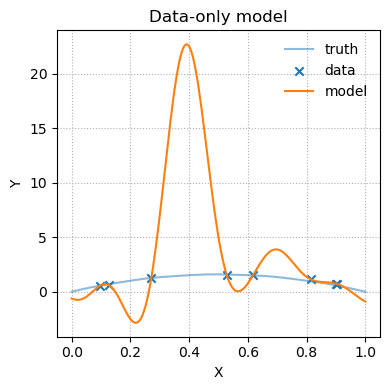

In [5]:
# Part 4.
theta1 = np.linalg.solve(A_data, b_data)
y_pred = phi(x_truth) @ theta1

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Data-only model')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(linestyle=':')
ax.plot(x_truth, y_truth, alpha=0.5, label='truth')
ax.scatter(x_train, y_train, marker='x', label='data')
ax.plot(x_truth, y_pred, label='model')
#ax.plot(x_plot, yp_poly, label='poly (K=4)', color='C1')
#ax.plot(x_plot, yp_gauss, label='gauss (K=10)', color='C2')
ax.legend(frameon=False)
fig.tight_layout()

In [6]:
# Part 5.
theta2 = np.linalg.solve(A_pde, b_pde)
y_pred = phi(x_truth) @ theta2

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Physics-only model')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(linestyle=':')
ax.plot(x_truth, y_truth, alpha=0.5, label='truth')
ax.scatter(x_train, y_train, marker='x', label='data')
ax.plot(x_truth, y_pred, label='model')
#ax.plot(x_plot, yp_poly, label='poly (K=4)', color='C1')
#ax.plot(x_plot, yp_gauss, label='gauss (K=10)', color='C2')
ax.legend(frameon=False)
fig.tight_layout()

LinAlgError: Singular matrix

Part 6.

Out of the three models tested here, the best is the physics-informed model, which was trained using 8 data points and used the physical PDE as regularization.

The model that only used the 8 data points was ill-posed, as it had far more parameters than weights, i.e. was underdetermined. Therefore the model was able to exactly interpolate the 8 training data points, but we can see from the plot that it performs very poorly on test data.

I was not able to fit a regression model using only the physical PDE with no training data. The coefficient matrix that needed to be inverted in order to find the optimal weights was not invertible. This means that its columns were linearly dependent, implying that there were fewer independent equations than unknowns. In other words, the system was underdetermined, and could admit multiple possible solutions. This makes sense, given that we usually need initial conditions or boundary conditions (i.e. data) in order to find a unique solution to a partial differential equation.

By combining the 8 training data points with the physical PDE as regularization, the resulting regression model solved the problem well. It is quite accurate on both training and test data without overfitting to noise in the training data. The addition of the physical constraint helped limit the space of plausible models that would fit the small training data set, resulting in an accurate solution despite limited data.